In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def resetq():
    global rho,rhov,p
    q=zeros([3,200], dtype=float)
    rho=q[0,:]
    rhov=q[1,:]
    p=q[2,:]
    rho+=1
    p+=1
    rhov+=1
    q[:,10:30]*=2
    return q

def sodq():
    global rho,rhov,p
    q=zeros([3,200], dtype=float)
    rho=q[0,:]
    rhov=q[1,:]
    p=q[2,:]
    rho+=1
    p+=1
    rho[10:100]*=10
    p  [10:100]*=10 
    return q

def blastq():
    global rho,rhov,p
    q=ones([3,200], dtype=float)
    rho=q[0,:]
    rhov=q[1,:]
    p=q[2,:]
    rhov*=0
    p[50:60]*=10
    return q


In [3]:
def advectUpwind (Q, dt=0.1, dx=1):
    u=(Q[1,1:-1]/Q[0,1:-1]).reshape([1,Q.shape[1]-2])
    Q[:,1:-1]-=dt/dx*u*(Q[:,1:-1]-Q[:,0:-2])

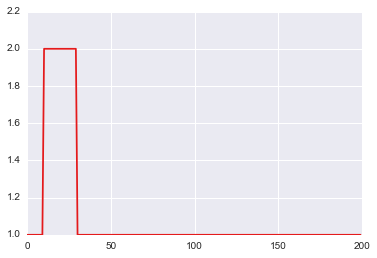

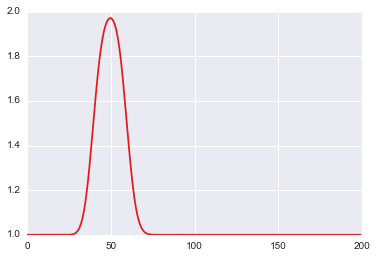

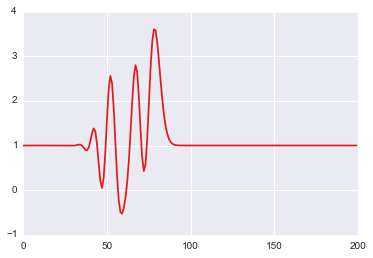

In [6]:
q=resetq()
plot(rho)
figure()
for i in xrange(100):
    advectUpwind(q,dt=0.3)
plot(rho)
figure()
for i in xrange(10):
    advectUpwind(q,dt=3)
plot(rho)

simple 1D upwind advection scheme, showing instability when CFL condition is broken and numerical diffusion when it is satisfied

In [7]:
def advectLW (Q, dt=0.1, dx=1):
    eps=dt/dx*(Q[1,1:-1]/Q[0,1:-1]).reshape([1,Q.shape[1]-2])
    Q[:,1:-1]+= -eps*(Q[:,2:] - Q[:,0:-2])/2\
                +eps**2*(Q[:,2:] - 2*Q[:,1:-1] +Q[:,0:-2])/2

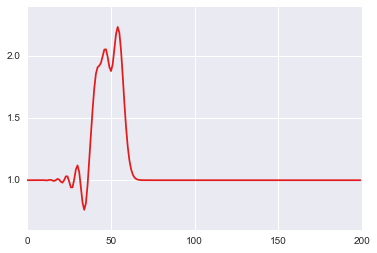

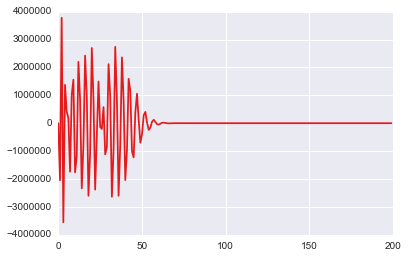

In [8]:
q=resetq()
for i in xrange(100):
    advectLW(q,dt=0.3)
plot(rho)
figure()
for i in xrange(10):
    advectLW(q,dt=3)
plot(rho)
q=resetq()

The Lax-wendroff scheme showing less numerical diffusion but some spurious oscilation upstream

In [9]:
class grid1D(object):
    def __init__(self, rho, rhov,p, dx=1, gamma=5./3):
        assert rho.shape==rhov.shape==p.shape
        assert len(rho.shape)==len(rhov.shape)==len(p.shape)==1
        self.nx=rho.shape[0]
        rho =concatenate([array([0,0]),rho ,array([0,0])])
        rhov=concatenate([array([0,0]),rhov,array([0,0])])
        p   =concatenate([array([0,0]),p   ,array([0,0])])
        rhoe=p/(gamma-1)+rhov**2/2/rho
        self.Q=array([rho,rhov,rhoe])#
        self.rho=self.Q[0,:]      # density momentum and pressure are stored in a 3xN state array
        self.rhov=self.Q[1,:]     # but can be acessed separately through rho, rhov and rho_etot
        self.rhoe=self.Q[2,:]        #
        self.p=empty_like(self.rhoe) #array for holding calculated pressures
        self.gamma=gamma          #adiabatic index
        self.S=1         #cell area for flux
        self.v=self.S*dx #cell volume
        self.dx=ones_like(self.rho)*dx
        self.flux=zeros([3,rho.shape[0]-1], dtype=float)
        self.uc=self.rhov/self.rho          #cell velocities
        self.uf=zeros_like(self.flux[0,:])#face velocities
        self.tmp=empty_like(self.Q)
        self.mask=self.uf==1
        #N.B one more flux point than rho,pressure point
        #there are N-1 shared boundaries of the cells and 2 edge ones
        #flux[i]  =left boundary for rho[i]
        #flux[i+1]=right boundary for rho[i]
        self.imposeBCs()
        
    def advect(self, dt=0.1):
        "advection using fluxes"
        tmp=self.tmp[:,1:-1]
        tmp[...]=self.flux[:,:-1]
        tmp-=self.flux[:,1:]
        tmp/=self.dx[1:-1]
        tmp*=dt
        self.Q+=self.tmp
        self.uc[...]=self.rhov/self.rho
        
    def calcFlux(self, dt=0.1):
        "simple donor cell method of calculaing fluxes, assumes piece-wise constant values of Q"
        self.uf=(self.rhov[0:-1]/self.rho[0:-1]+
                 self.rhov[1:  ]/self.rho[1:  ])/2
        self.mask[...]=self.uf>0
        self.flux=(where(self.mask.reshape((1,self.nx+3)),
                         self.Q[:,:-1],
                         self.Q[:,1:])*
                   self.uf.reshape((1,self.nx+3)))
            
    def imposeBCs(self):
        self.Q[:,0:2 ]=self.Q[:,-4:-2]
        self.Q[:,-2:]=self.Q[:,2:4]
#        self.flux[:,0 ]=self.flux[:,-1]
#        self.flux[:,-1]=self.flux[:,1]    

            
    def timestep(self, dt=0.1):
        self.calcFlux(dt)
        self.advect(dt)
        self.imposeBCs()

In [10]:
q=resetq()
grid=grid1D(rho,rhov,p)

216.0
216.0


(200,)

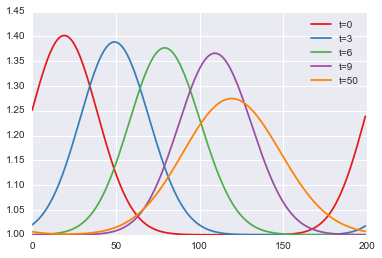

In [12]:
print rho[2:-2].sum()
plot(grid.rho[2:-2])
for i in xrange(300):    grid.timestep()
plot(grid.rho[2:-2])
for i in xrange(300):    grid.timestep()
plot(grid.rho[2:-2])
for i in xrange(300):    grid.timestep()
plot(grid.rho[2:-2])
for i in xrange(4100):    grid.timestep()
plot(grid.rho[2:-2])
print rho[2:-2].sum()
legend(['t=0','t=3','t=6','t=9','t=50'])
grid.rho[2:-2].shape

1D piecwise cells advecting using a donor cell scheme and periodic boundary conditions

In [13]:
def minmod (a,b):
    if a*b < 0: return 0
    else:
        if abs(a) < abs(b): return a
        else: return b
    
def minmodarray(a,b):
    ret=zeros_like(a)
    mask=a*b>0
    ret[mask]=where(abs(a)>abs(b),b,a)[mask]
    return ret
               
def maxmod (a,b):
    if a*b < 0: return 0
    else:
        if abs(a) > abs(b): return a
        else: return b

def maxminmin (a,b,c,d,e):
    return maximum(a,maximum(minimum(b,c),minimum(d,e))) #for superbee fluxlimiter

In [23]:
class grid1D_superbee(grid1D):
    def __init__(self, rho, rhov,p, dx=1):
        super(grid1D_superbee,self).__init__(rho, rhov,p, dx)
        self.sgn=ones_like(self.uc)
        self.r=empty_like(self.flux[:,:-2])
        self.phi=empty_like(self.r)

    def calcFlux(self, dt=0.1):
        self.r1=(self.Q[:,1:-2]-self.Q[:,0:-3])/(self.Q[:,2:-1]-self.Q[:,1:-2])
        self.r2=(self.Q[:,3:  ]-self.Q[:,2:-1])/(self.Q[:,2:-1]-self.Q[:,1:-2])
        self.r1[isnan(self.r1)]=0
        self.r2[isnan(self.r2)]=0
        self.sgn[...]=sign(self.uc)
        self.r[...]=where((self.sgn[2:-1]>=1).reshape((1,self.nx+1)),
                           self.r1.reshape((3,self.nx+1)),self.r2.reshape((3,self.nx+1)))

       # print maxminmin(0,1,2*self.r,2,self.r)
        self.phi[...]=maxminmin(0,1,2*self.r,2,self.r)
        super(grid1D_superbee,self).calcFlux(dt)
        self.flux[:,1:-1]+=(abs(self.uf[1:-1]) * (1-abs(self.uf[1:-1])*dt/self.dx[1:-2])*
                            self.phi*(self.Q[:,2:-1]-self.Q[:,1:-2]))/2
    
    def sourceTerms(self,dt):
#        self.uc[...]    =self.rhov/self.rho
        self.rhov[1:-1]-=dt*(self.p[2:]-self.p[:-2])/(2*self.dx[1:-1])
        self.rhoe[1:-1]-=dt*(self.p[2:]*self.uc[2:]-self.p[:-2]*self.uc[:-2])/(2*self.dx[1:-1])        
        
    def eos (self):
        "fills pressure array with newly calculated pressures"
        if self.gamma-1>1e-6:
            self.p[...]=(self.gamma-1)*self.rho * (self.rhoe/self.rho - (self.rhov/self.rho)**2/2)
        else:
            self.p[...]=self.rho*1**2
            
#    def imposeBCs(self):
#        self.Q[0,:2]=2
#        self.Q[1,:2]=10
#        self.Q[2,:2]=10**2/2+1*2
#        self.Q[:,-2:]=self.Q[:,-4:-2]
#        self.Q[1,-2:][self.Q[1,-2:]<0]=0
        
    def cfl(self):
        return (self.dx/(abs(self.rhov)/self.rho)).min()
        
    def timestep (self, dt=0.1):
        Dt=min(dt, self.cfl()*0.6)
#        super(grid1D_superbee,self).calcFlux(dt)
        self.calcFlux(Dt)
        self.advect(Dt)
        self.eos()
        self.sourceTerms(Dt)
        self.imposeBCs()

In [26]:
q=sodq()
grid=grid1D_superbee(rho,rhov,p,dx=0.1)
grid.eos()

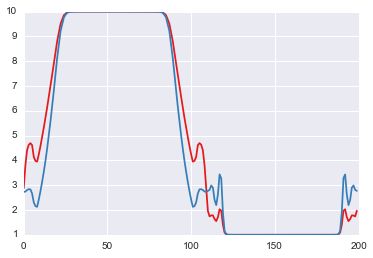

In [27]:
for i in xrange(100):    grid.timestep(0.01)
plot(grid.rho[2:-2])
plot(grid.p[2:-2])

1006.0
1006.0


(200,)

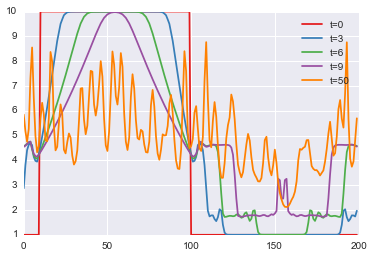

In [25]:
print rho[2:-2].sum()
plot(grid.rho[2:-2])
for i in xrange(100):    grid.timestep(0.01)
plot(grid.rho[2:-2])
for i in xrange(100):    grid.timestep(0.01)
plot(grid.rho[2:-2])
for i in xrange(100):    grid.timestep(0.01)
plot(grid.rho[2:-2])
for i in xrange(4100):    grid.timestep(0.01)
plot(grid.rho[2:-2])
print rho[2:-2].sum()
legend(['t=0','t=3','t=6','t=9','t=50'])
grid.rho[2:-2].shape

In [ ]:
plot(grid.rho[120:170],linestyle='steps-mid')
plot(grid.p[120:170],linestyle='steps-mid')
plot(grid.rhoe[120:170],linestyle='steps-mid')
plot(grid.uc[120:170],linestyle='steps-mid')
#plot(minmodarray(ones_like(grid.r[1,100:150]),grid.r[1,100:150])*5,linestyle='steps-mid')
legend(['rho','p','rhoe','uc'])

In [ ]:
plot(grid.rho)
plot(grid.phi[0,:])

In [ ]:
a=array([1,2,3,-4,-5,-6,-7])
b=array([7,-6,-5,-4,-3,-2,1])